In [1]:
import numpy as np
import re

In [6]:
from sklearn.datasets import fetch_20newsgroups as getData

In [3]:
from scipy.sparse import lil_matrix

In [7]:
data = getData(subset='train',remove=('headers','footers','quotes'))
X=data.data

In [9]:
x = ' '.join(X)


In [11]:
len(x)

13793298

In [12]:
x = x.lower()

In [13]:
corpus_list = re.split('\W',x)

In [14]:
len(corpus_list)

3807553

In [102]:
cutOffValue = 50
from collections import defaultdict
frequency = defaultdict(int)
for token in corpus_list:
    frequency[token] += 1
processedCorpus_list = [token for token in corpus_list if frequency[token] > cutOffValue ]

In [103]:
len(processedCorpus_list)

3423482

In [104]:
allWords = np.array(list(frequency.keys()))
allCounts = np.array(list(frequency.values()))

In [105]:
vocab = allWords[allCounts >= cutOffValue]
wordCounts = allCounts[allCounts >= cutOffValue]

In [195]:
len(processedCorpus_list)

3423482

In [106]:
def computeWordContextMatrix(corpus_list,vocab=None,window_size=2):
    if vocab is None:
        vocab=sorted(list(set(corpus_list)))
    numWords = len(vocab)
    #M = np.zeros((numWords,numWords))
    M = lil_matrix((numWords,numWords))
    W2I = dict(zip(vocab,np.arange(numWords)))
    I2w = dict(zip(np.arange(numWords),vocab))
    doc = corpus_list
    curIdx = 0
    docLen = len(doc)
    while curIdx < docLen:
        left = max(curIdx-window_size,0)
        right = min(curIdx+window_size+1,docLen)
        wordsInContext = doc[left:curIdx] + doc[curIdx+1:right]
        currentWord=doc[curIdx]
        currentWordIdx = W2I[currentWord]
        for word in wordsInContext:
            contextIdx = W2I[word]
            M[currentWordIdx,contextIdx] += 1
        curIdx += 1
    return M,W2I,I2w
            

In [174]:
M,W2I,I2W = computeWordContextMatrix(processedCorpus_list,vocab)

In [120]:
sorted(np.sum(M,axis=1))[-1]

matrix([[5601541.]])

In [116]:
I2W[0]

'i'

In [ ]:
np.outer()

In [ ]:
np.isinf()

In [177]:
M2 = M.copy()

In [214]:
def pmi(M,positive=True):
    col_totals = np.sum(M,axis=0)
    total = col_totals.sum()
    row_totals = np.sum(M, axis=1)
    #print(col_totals,'\n',row_totals)
    expected = np.outer(row_totals,col_totals) / total
    #print(expected)
    
    M = M / expected
    with np.errstate(divide='ignore'):
        M = np.log(M)
    #M[np.isinf(M)] = 0.0
    
    
    
    if positive:
        M[M<0]=0.0
    return M

In [215]:
M2 = pmi(M)

F:\anaconda\Lib\site-packages\scipy\sparse\_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)


In [196]:
M2.shape

(4327, 4327)

In [218]:
np.min(M2)

nan

In [169]:
# def calculate_pmi(matrix,positive=True):
#     # Convert the matrix to probabilities
#     p_xy = matrix / np.sum(matrix)
#     p_x = np.sum(matrix, axis=1) / np.sum(matrix)
#     p_y = np.sum(matrix, axis=0) / np.sum(matrix)
    
#     # Avoid division by zero
#     p_x[p_x == 0] = 1
#     p_y[p_y == 0] = 1
    
#     # Calculate PMI
#     pmi_matrix = np.log2(p_xy / (np.outer(p_x, p_y)))
    
# #     if positive:
# #         pmi_matrix[pmi_matrix<0] = 0.0
#     return pmi_matrix

In [173]:
M = calculate_pmi(M)

In [219]:
M2 = np.nan_to_num(M2,nan=0.0)

In [220]:
np.min(M2)

0.0

In [200]:
M2[np.isnan(M2)]

(1, 643425)

(1, 0)

In [5]:
from sklearn.decomposition import TruncatedSVD,PCA,IncrementalPCA

In [221]:
transformer = TruncatedSVD(n_components=100)
M_reduced = transformer.fit_transform(M2)

F:\anaconda\Lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [222]:
# transformerPca = IncrementalPCA(n_components=100)
# M_reduced_pca = transformerPca.fit_transform(M)
# M_reduced_pca[0]

In [325]:
np.min(M_reduced)

-14.71154543042965

In [206]:
M.shape

(4327, 4327)

In [326]:
np.sum(np.isnan(M_reduced))

0

In [497]:
def getNorms(E):
    if E.ndim <= 1:
        E = E[np.newaxis,:]
    nrms =  np.sum(E**2,axis=1)**0.5
    return nrms

In [256]:
print(getNorms(M_reduced[1,:]))

[34.32019928]


In [271]:
def normalize(E):
 #   if E.ndim ==1:
#        E = E[np.newaxis,:]
#     for i in range(E.shape[0]):
#         nrms = getNorms(E[i][np.newaxis,:])
#         print(nrms,np.sqrt(nrms))
#         E[i] = E[i]/(np.sqrt(nrms))
    nrms = getNorms(E)

#     print(nrms[:,np.newaxis])
#     print(nrms.shape)
#     print(E.shape)
    return E / nrms[:,np.newaxis]

In [262]:
E = M_reduced[1,:]
norm_E = normalize(E)
print(np.sum(norm_E,axis=1))

[[34.32019928]]
(1,)
(100,)
[0.47660618]


In [253]:
np.sum(norm_E,axis=1)

array([0.47660618])

In [264]:
np.sum(M_reduced[1])

16.357219017403168

In [267]:
np.sum(M_reduced[1]**2)**0.5

34.32019927633177

In [268]:
getNorms(norm_E)

array([1.])

In [330]:
def cosineSimilarity(E,v):
    E = normalize(E)
    v = normalize(v)
    scores = E.dot(v.T)
    scores[np.isnan(scores)] = 0.0
    return scores

In [508]:
def getMostSimilarWords(E,word,W2I,topn=10):
    if type(word) is str:
        v = E[W2I[word],:]
    else:
        v = word
    scores = cosineSimilarity(E,v)
    print(scores)
    sortedScores = np.sort(scores.reshape(-1))[::-1]
    print(sortedScores.shape)
    print(np.sum(np.isnan(sortedScores)))
    idx = np.argsort(scores.reshape(-1))[::-1]
    topNScores = sortedScores[1:]
    topNWordsIdx = idx[1:]
    return topNScores,topNWordsIdx
        

In [362]:
E.shape

(100,)

In [375]:
scores, idx = getMostSimilarWords(M_reduced,'hello',W2I)

[[0.24114608]
 [0.28139872]
 [0.35245551]
 ...
 [0.06448628]
 [0.05556236]
 [0.37626089]]
(4327,)
0


C:\Users\Mohammad\AppData\Local\Temp\ipykernel_1864\1797927720.py:13: RuntimeWarning: invalid value encountered in divide
  return E / nrms[:,np.newaxis]


In [376]:
print(scores)
print(idx)

[0.70703512 0.70240866 0.65376879 0.62265067 0.61971857 0.61676366
 0.60392609 0.58373418 0.57491022]
[1459  109 4061 1594  237 1625 1074  392  437]


In [377]:
scores

array([0.70703512, 0.70240866, 0.65376879, 0.62265067, 0.61971857,
       0.61676366, 0.60392609, 0.58373418, 0.57491022])

In [378]:
idx

array([1459,  109, 4061, 1594,  237, 1625, 1074,  392,  437], dtype=int64)

In [379]:
for i in idx:
    print(I2W[i])

sorry
thanks
dear
hi
com
wrote
ed
thanx
hey


In [380]:
import dill

In [381]:
def saveModel(model,filename):
    with open(filename, 'wb') as f:
        dill.dump(model,f)
def loadModel(filename):
    with open(filename,'rb') as file:
        return dill.load(file)
        

In [382]:
import pandas as pd

In [384]:
from gensim.models import KeyedVectors

In [386]:
with open('glove.6B.100d.txt','r') as file:
    text = file

In [403]:
model = KeyedVectors.load_word2vec_format('glove.6B.100d.txt',binary=False,no_header=True)

In [404]:
saveModel(model,'w2v_100d.pkl')

In [429]:
I2W = model.index_to_key
W2I = model.key_to_index
#E = model.keys()

In [421]:
import numpy as np

def load_glove_model(file_path):
    model = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            model[word] = vector
    return model

def get_embedding_matrix(model):
    words = list(model.keys())
    embedding_matrix = np.vstack([model[word] for word in words])
    return words, embedding_matrix

# Replace 'path/to/your/glove_file.txt' with the actual path to your GloVe file
glove_file_path = 'glove.6B.100d.txt'

# Load GloVe model
glove_model = load_glove_model(glove_file_path)

# Get embedding matrix
words, embedding_matrix = get_embedding_matrix(glove_model)

# Print the words and the embedding matrix
print("Words:", words)
print("Embedding Matrix Shape:", embedding_matrix.shape)
E = embedding_matrix

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [449]:
scores , idx = getMostSimilarWords(E,E[W2I['good']],W2I)

[[ 0.6249901 ]
 [ 0.64267707]
 [ 0.6907098 ]
 ...
 [-0.2975428 ]
 [-0.47232828]
 [-0.42604652]]
(400000,)
0


In [450]:
for i in range(len(idx)):
    print(I2W[idx[i]])

better
sure
really
kind
very
we
way
think
thing


In [430]:
W2I['good']

219

In [438]:
def analogies(E,W2I,man,woman,king):
    word = E[W2I[king]]-E[W2I[man]]+E[W2I[woman]]
    scores, idx= getMostSimilarWords(E,word,W2I)
    return scores,idx

In [441]:
scores,idx = analogies(E,W2I,'tall','long','short')

[[ 0.6104524 ]
 [ 0.54657996]
 [ 0.59741277]
 ...
 [-0.39674562]
 [-0.35540912]
 [-0.27958274]]
(400000,)
0


In [442]:
for i in range(len(idx)):
    print(I2W[idx[i]])

long
end
term
time
during
extended
recent
direct
taking


In [443]:
def reduceDim(X,new_dim=3):
    pca = PCA(n_components=new_dim)
    pca.fit(X)
    X_new = pca.transform(X)
    return X_new

In [444]:
E_new = reduceDim(E)


In [447]:
E_new

array([[ 5.8668003 ,  0.19819295,  0.981269  ],
       [ 5.563016  ,  1.7808332 ,  0.71480095],
       [ 5.695895  ,  0.90337276,  0.265031  ],
       ...,
       [-0.69032574, -0.01435895, -0.5454169 ],
       [-1.3291447 ,  0.07377893,  0.023563  ],
       [-0.9986323 ,  0.48808107, -0.2723436 ]], dtype=float32)

In [448]:
getMostSimilarWords(E_new,'good',W2I)

AttributeError: 'str' object has no attribute 'ndim'

In [451]:
import seaborn as sns
import matplotlib.pyplot as plt

In [480]:
similar_words = E_new[idx]

TypeError: bad operand type for unary ~: 'list'

In [455]:
similar_words.shape

(9, 3)

In [456]:
non_similar_wordsvecx.shape

(9, 3)

In [458]:
from mpl_toolkits.mplot3d import Axes3D

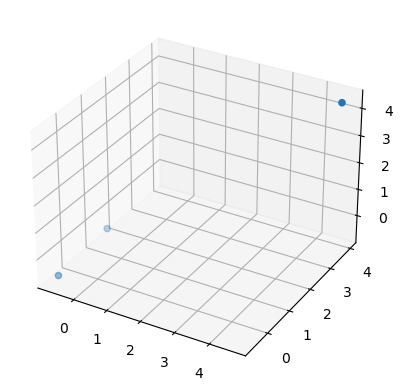

In [460]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(similar_words[0],similar_words[1],similar_words[2])

In [ ]:
sns.scatterplot(similar_words[0],similar_words[1],)

In [461]:
import plotly.express as px
df = pd.DataFrame(similar_words)

In [462]:
df

,0,1,2
0,4.630084,0.019006,-0.713646
1,3.956667,0.419062,-0.645862
2,4.295525,0.543946,-0.686984
3,4.312874,-0.165040,-0.613786
4,4.938601,0.527675,-0.475359
5,5.702342,0.796246,-0.657362
6,5.143403,0.122869,-0.096464
7,4.561670,0.598837,-0.367795
8,4.010604,0.136925,-0.482669


In [512]:
def plot3D(x,y,z):
    df = pd.DataFrame({'X':x,'Y':y,'Z':z})
    fig1 = px.scatter_3d(df[:10],x='X',y='Y',z='Z')
    fig2 = px.scatter_3d(df[-10:],x='X',y='Y',z='Z')
    traces = fig2.data

# Add traces from the second plot to the first plot
    for trace in traces:
        fig1.add_trace(trace)

# Show the combined plot
    fig1.show()
    

In [486]:
plot3D(similar_words[:,0],similar_words[:,1],similar_words[:,0])

In [489]:
similar_words.shape

(9, 3)

In [496]:
E.shape

(400000, 100)

In [509]:
scores, idx = getMostSimilarWords(E,'good',W2I,4000000)
E_similar = E[idx]
E_reduced_dim = reduceDim(E_similar)


[[ 0.6249901 ]
 [ 0.64267707]
 [ 0.6907098 ]
 ...
 [-0.2975428 ]
 [-0.47232828]
 [-0.42604652]]
(400000,)
0


In [510]:
E_reduced_dim.shape

(399999, 3)

In [513]:
plot3D(E_reduced_dim[:,0],E_reduced_dim[:,1],E_reduced_dim[:,0])